# ***Data Pipeline for IMDB Reviews***

# 1. Data Loading
Load each dataset separately into Pandas.


Standardize columns:


reviews column → review.


sentiments column → label.


Document dataset size (rows, columns).


Remove duplicates and missing values.


Deliverable (per dataset):
Table: Dataset | Original size | Cleaned size | Removed rows.


Save as imdb_clean.csv


In [ ]:
# Imports and load dataset
# Import required libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize  # Import the tokenizer

import contractions

import re
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

import warnings
warnings.filterwarnings('ignore')

from pathlib import Path

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

sns.set(style='whitegrid')

# set required variables
separator='\n-------------------------------------------------------------------------------------------------------'
data_path = Path('data/IMDB_Dataset.csv')
cleaned_data_path = Path('cleaned_data/imdb_clean.csv')
label_distribution_chart_path = Path('results/imdb/label_distribution.png')
class_balance_path = Path('results/imdb/class_balance.png')
train_df_path = Path('splits/imdb_train.csv')
test_df_path = Path('splits/imdb_test.csv')
# Load the dataset

print("Loading IMDB dataset...")
df = pd.read_csv(data_path)
print('Dataset loaded from', data_path)
print(separator)

# Check dataset structure

print("\nFirst 5 rows:")
print(df.head())
print(separator)
print("\nDataset shape:", df.shape)
print(separator)
print("\nDataset info:")
print(df.info())
print(separator)
print("\nDuplications in the Dataset:")
print(df.duplicated().sum())
print(separator)
print("\nMissing Values in the Dataset:")
print(df.isnull().sum())



Loading IMDB dataset...
Dataset loaded from data\IMDB_Dataset.csv

-------------------------------------------------------------------------------------------------------

First 5 rows:
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

-------------------------------------------------------------------------------------------------------

Dataset shape: (50000, 2)

-------------------------------------------------------------------------------------------------------

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  -----

In [45]:
# Standardize columns
df = df.rename(columns={"review": "review", "sentiment": "label"})

# Document original size
original_size = df.shape
print(f"Original dataset size: {original_size}")
print(separator)

# Remove duplicates
df_clean = df.drop_duplicates()

# Remove missing values
df_clean = df_clean.dropna()

# Document cleaned size
cleaned_size = df_clean.shape
removed_rows = original_size[0] - cleaned_size[0]

print(f"Cleaned dataset size: {cleaned_size}")
print(f"Removed rows: {removed_rows}")
print(separator)
# Create summary table
summary_table = pd.DataFrame({
    'Dataset': ['IMDB'],
    'Original Size': [original_size[0]],
    'Cleaned Size': [cleaned_size[0]],
    'Removed Rows': [removed_rows]
})
print("\n Summary Table:\n")
display(summary_table)
print(separator)
# Save cleaned dataset
df_clean.to_csv(cleaned_data_path, index=False)
print(f"Deliverable: \nCleaned dataset saved to : {cleaned_data_path}")

print(separator)
print("\nDataset shape after removing duplicates and Null values:", df_clean.shape)


Original dataset size: (50000, 2)

-------------------------------------------------------------------------------------------------------
Cleaned dataset size: (49582, 2)
Removed rows: 418

-------------------------------------------------------------------------------------------------------

 Summary Table:



,Dataset,Original Size,Cleaned Size,Removed Rows
0,IMDB,50000,49582,418



-------------------------------------------------------------------------------------------------------
Deliverable: 
Cleaned dataset saved to : cleaned_data\imdb_clean.csv

-------------------------------------------------------------------------------------------------------

Dataset shape after removing duplicates and Null values: (49582, 2)


# 2. Exploratory Data Analysis (EDA)
Print 5 random samples.


Count samples per label.


Plot label distribution (bar chart).
Deliverable (per dataset):
PNG chart: label distribution.


Short note: “Dataset X has Y% positive and Z% negative reviews.”


5 Random Samples from the Dataset:


,review,label
30286,this has by far been one of the most beautiful...,positive
4748,"Given the title and outlandish box art, I was ...",negative
26940,"Simply put, Oliver! is one of the greatest mus...",positive
22523,I simply never tire of watching FREEBIRD. My h...,positive
6581,I disagree with Dante portraying the Democrat-...,negative



-------------------------------------------------------------------------------------------------------

Label Distribution:
label
positive    24884
negative    24698
Name: count, dtype: int64

-------------------------------------------------------------------------------------------------------


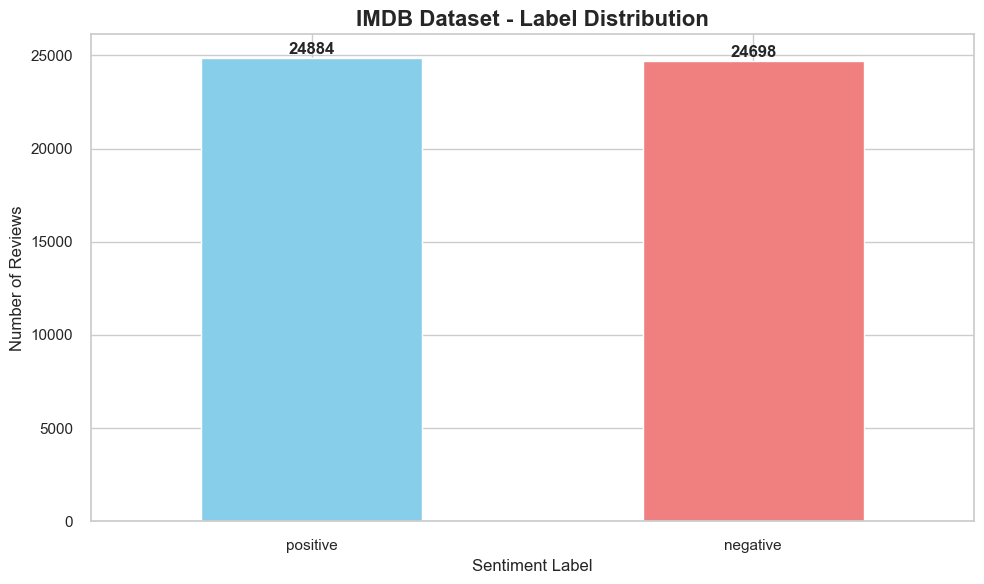


-------------------------------------------------------------------------------------------------------

Dataset has 50.19% positive and 49.81% negative reviews.


In [46]:
# Print 5 random samples
print("5 Random Samples from the Dataset:")
display(df_clean.sample(5))
print(separator)

# Count samples per label
label_counts = df_clean['label'].value_counts()
print("\nLabel Distribution:")
print(label_counts)
print(separator)

# Plot label distribution
plt.figure(figsize=(10, 6))
ax = label_counts.plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('IMDB Dataset - Label Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Sentiment Label', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.xticks(rotation=0)

# Add value labels on bars
for i, v in enumerate(label_counts):
    ax.text(i, v + 50, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(label_distribution_chart_path, dpi=300, bbox_inches='tight')
plt.show()
print(separator)

# Calculate percentages
total_reviews = len(df_clean)
positive_pct = (label_counts['positive'] / total_reviews) * 100
negative_pct = (label_counts['negative'] / total_reviews) * 100

print(f"\nDataset has {positive_pct:.2f}% positive and {negative_pct:.2f}% negative reviews.")

# 3. Text Cleaning
Convert to lowercase.

Remove HTML tags, emojis, numbers, special characters.

Remove extra spaces.

Save cleaned text in clean_text column.

Expand Contractions: Convert contractions like "don't" to "do not" for standardization.

Tokenization using punkt (MUCH BETTER than split()): Split text into individual words or tokens.

Text Normalization:

Remove Stop Words: Filter out common words (e.g., "the", "a", "is") that add little meaning.

Perform Lemmatization: 
Reduce words to their base or dictionary form (e.g., "running" -> "run", "better" -> "good").
Show before/after examples (5 reviews).


Deliverable (per dataset):
Updated CSV with clean_text.
Table: original vs cleaned text (5 samples).


In [ ]:
# Download required NLTK data (run this once)
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')       # For advanced tokenization
nltk.download('punkt_tab')

# Initialize lemmatizer and stopwords list
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to C:\Users\Eng. Ahmed
[nltk_data]     Nabil\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to C:\Users\Eng. Ahmed
[nltk_data]     Nabil\AppData\Roaming\nltk_data...
[nltk_data] Downloading package omw-1.4 to C:\Users\Eng. Ahmed
[nltk_data]     Nabil\AppData\Roaming\nltk_data...


In [ ]:
def clean_text(text):
    """
    Comprehensive text cleaning function
    """
    if not isinstance(text, str):
        return ""
    
    # Convert to lowercase
    text = text.lower()

    # Expand contractions using the contractions library
    text = contractions.fix(text)
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove emojis and special characters (keep only letters and basic punctuation)
    text = re.sub(r'[^a-zA-Z\s\.\,\!\?]', '', text)

    # Tokenize using punkt (MUCH BETTER than split())
    words = word_tokenize(text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Tokenization (split into words)
    #words = text.split()
    
    # Remove stopwords and lemmatize
    cleaned_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words and len(word) > 2]
    
    # Join the words back into a single string
    cleaned_text = ' '.join(cleaned_words)
    
    return cleaned_text

# Apply text cleaning
print("Cleaning text data...")
df_clean['clean_text'] = df_clean['review'].apply(clean_text)

# Show before/after examples
print("\nText Cleaning Examples:")
sample_indices = df_clean.sample(5).index
cleaning_examples = []

for idx in sample_indices:
    original = df_clean.loc[idx, 'review'][:200] + "..." if len(df_clean.loc[idx, 'review']) > 200 else df_clean.loc[idx, 'review']
    cleaned = df_clean.loc[idx, 'clean_text'][:200] + "..." if len(df_clean.loc[idx, 'clean_text']) > 200 else df_clean.loc[idx, 'clean_text']
    cleaning_examples.append({
        'Original': original,
        'Cleaned': cleaned
    })

cleaning_df = pd.DataFrame(cleaning_examples)
display(cleaning_df)

# Save updated dataset
df_clean.to_csv(cleaned_data_path, index=False)
print("\nUpdated dataset with cleaned text saved.")

Cleaning text data...

Text Cleaning Examples:


,Original,Cleaned
0,I usually don't comment anything (i read the o...,usually dont comment anything read others opin...
1,"...a true geek-girl's dream: high tech, high d...","...a true geekgirls dream high tech, high dram..."
2,Complete waste of time.... This movie is not c...,"complete waste time.... movie comedy, drama, r..."
3,I went to see the Omega Code with a group of o...,went see omega code group christian totaling p...
4,A MUST SEE! I saw WHIPPED at a press screening...,must see! saw whipped press screening hilariou...



Updated dataset with cleaned text saved.


# 4. Label Encoding

Convert labels to numeric (0/1).

Document mapping (0 = negative, 1 = positive).

Verify by printing first 10 rows.

Deliverable (per dataset):
Updated CSV with numeric labels.


Note: label mapping used.


In [48]:
# Convert labels to numeric
label_mapping = {'negative': 0, 'positive': 1}
df_clean['label_numeric'] = df_clean['label'].map(label_mapping)

# Verify encoding
print("Label Mapping:")
print(label_mapping)

print("\nFirst 10 rows with numeric labels:")
display(df_clean[['review', 'label', 'label_numeric']].head(10))

# Check if any labels weren't mapped
unmapped = df_clean[df_clean['label_numeric'].isna()]
if len(unmapped) > 0:
    print(f"Warning: {len(unmapped)} unmapped labels found:")
    print(unmapped['label'].unique())
else:
    print("All labels successfully mapped.")
print(separator)



# Save cleaned dataset
df_clean.to_csv(cleaned_data_path, index=False)
print(f"\nEncoded and Cleaned dataset with numeric labels saved to : {cleaned_data_path}")


Label Mapping:
{'negative': 0, 'positive': 1}

First 10 rows with numeric labels:


,review,label,label_numeric
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1
5,"Probably my all-time favorite movie, a story o...",positive,1
6,I sure would like to see a resurrection of a u...,positive,1
7,"This show was an amazing, fresh & innovative i...",negative,0
8,Encouraged by the positive comments about this...,negative,0
9,If you like original gut wrenching laughter yo...,positive,1


All labels successfully mapped.

-------------------------------------------------------------------------------------------------------

Encoded and Cleaned dataset with numeric labels saved to : cleaned_data\imdb_clean.csv



# 5. Class Balance Check
Count positive vs negative reviews.


Calculate percentages.


Create a bar chart (or pie chart).


Document if dataset is balanced or imbalanced.


If imbalance exists, note a future strategy:


Oversampling (e.g., SMOTE).


Undersampling (reduce majority class).


Class weights (adjust loss function).
Deliverable (per dataset):
PNG chart.


Table: Dataset | Positive % | Negative % | Status (Balanced/Imbalanced).

Class Distribution:


,Class,Count,Percentage
0,Negative (0),24884,50.187568
1,Positive (1),24698,49.812432


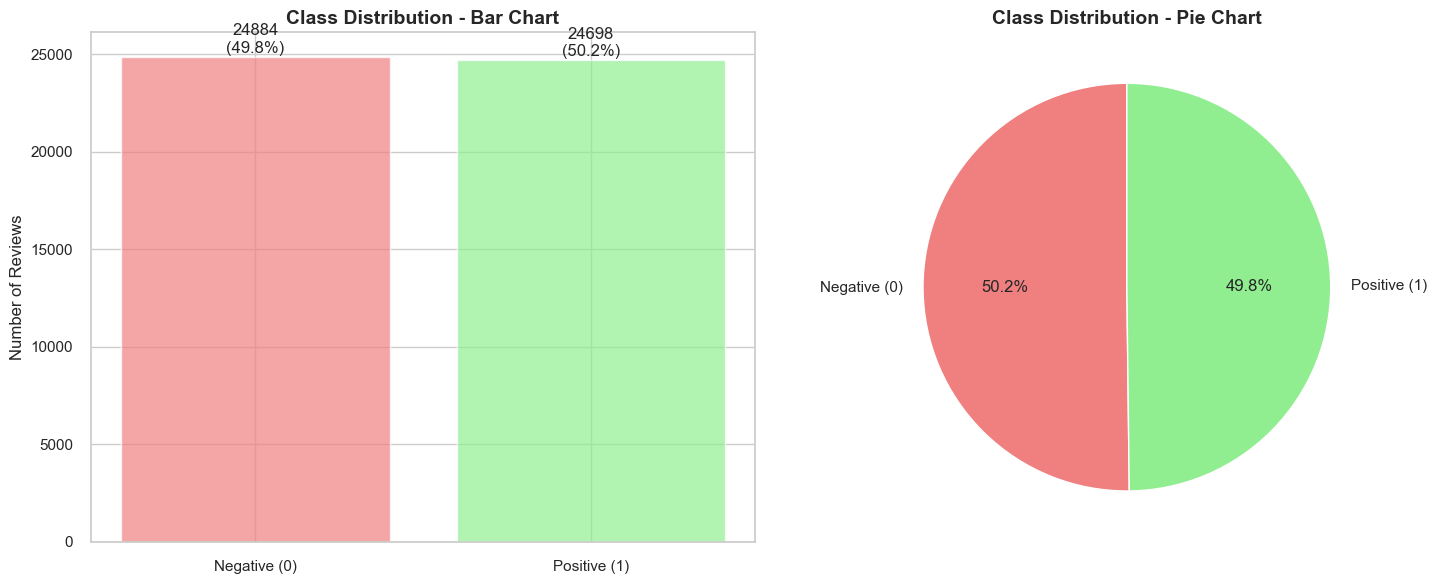


Dataset Status: Balanced


In [49]:
# Count positive vs negative reviews
class_counts = df_clean['label_numeric'].value_counts()
class_percentages = (class_counts / len(df_clean)) * 100

print("Class Distribution:")
balance_table = pd.DataFrame({
    'Class': ['Negative (0)', 'Positive (1)'],
    'Count': class_counts.values,
    'Percentage': class_percentages.values
})
display(balance_table)

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Bar chart
bars = ax1.bar(['Negative (0)', 'Positive (1)'], class_counts.values, 
               color=['lightcoral', 'lightgreen'], alpha=0.7)
ax1.set_title('Class Distribution - Bar Chart', fontsize=14, fontweight='bold')
ax1.set_ylabel('Number of Reviews', fontsize=12)

# Add value labels on bars
for bar, count in zip(bars, class_counts.values):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 50,
             f'{count}\n({class_percentages[bar.get_x() + bar.get_width()/2.]:.1f}%)',
             ha='center', va='bottom')

# Pie chart
colors = ['lightcoral', 'lightgreen']
ax2.pie(class_percentages, labels=['Negative (0)', 'Positive (1)'], 
        autopct='%1.1f%%', colors=colors, startangle=90)
ax2.set_title('Class Distribution - Pie Chart', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(class_balance_path, dpi=300, bbox_inches='tight')
plt.show()

# Determine if dataset is balanced
balance_threshold = 5  # percentage difference threshold
is_balanced = abs(class_percentages[0] - class_percentages[1]) < balance_threshold

status = "Balanced" if is_balanced else "Imbalanced"
print(f"\nDataset Status: {status}")

if not is_balanced:
    imbalance_degree = abs(class_percentages[0] - class_percentages[1])
    print(f"Imbalance degree: {imbalance_degree:.2f}%")
    print("\nFuture strategy recommendations:")
    print("1. Oversampling (e.g., SMOTE) - Create synthetic samples for minority class")
    print("2. Undersampling - Randomly remove samples from majority class")
    print("3. Class weights - Adjust loss function to penalize misclassification of minority class more")
    print("4. Collect more data for minority class")

# 6. Train/Test Split
Perform 80/20 split with stratification.


Record sizes of Train and Test.


Check class balance in both sets.


Deliverable (per dataset):
train.csv, test.csv.


Table: Dataset | Train size | Test size | Positive % | Negative %.


In [54]:
# Prepare features and target
X = df_clean['clean_text']
y = df_clean['label_numeric']

# Perform stratified train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

# Create train and test DataFrames
train_df = pd.DataFrame({
    'clean_text': X_train,
    'label': y_train
})

test_df = pd.DataFrame({
    'clean_text': X_test,
    'label': y_test
})

# Document split sizes
train_size = len(train_df)
test_size = len(test_df)

print(f"Train set size: {train_size} ({train_size/len(df_clean)*100:.1f}%)")
print(f"Test set size: {test_size} ({test_size/len(df_clean)*100:.1f}%)")
print(separator)

# Check class balance in splits
train_positive_pct = (train_df['label'].sum() / len(train_df)) * 100
train_negative_pct = 100 - train_positive_pct

test_positive_pct = (test_df['label'].sum() / len(test_df)) * 100
test_negative_pct = 100 - test_positive_pct

# Create split summary table
split_summary = pd.DataFrame({
    'Dataset': ['Train', 'Test'],
    'Size': [train_size, test_size],
    'Positive %': [f"{train_positive_pct:.2f}%", f"{test_positive_pct:.2f}%"],
    'Negative %': [f"{train_negative_pct:.2f}%", f"{test_negative_pct:.2f}%"]
})

display(split_summary)
print(separator)

# Save split datasets
train_df.to_csv(train_df_path, index=False)
print(f"\nTrain dataset saved to :  {train_df_path}")

test_df.to_csv(test_df_path, index=False)
print(f"\nTest dataset saved to :  {train_df_path}")

Train set size: 39665 (80.0%)
Test set size: 9917 (20.0%)

-------------------------------------------------------------------------------------------------------


,Dataset,Size,Positive %,Negative %
0,Train,39665,50.19%,49.81%
1,Test,9917,50.19%,49.81%



-------------------------------------------------------------------------------------------------------

Train dataset saved to :  splits\imdb_train.csv

Test dataset saved to :  splits\imdb_train.csv
